# Adversarial Search: Playing Connect 4

Student Name: [Nguyen Khai Ca]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [NKC]

## Learning Outcomes

* Implement adversarial search algorithms for strategic game play.
* Analyze and optimize search in complex game spaces.
* Design effective heuristic evaluation functions.
* Compare performance across different agent strategies.
* Evaluate algorithmic trade-offs between decision quality and efficiency.

## Instructions

Total Points: Undergraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file. 


## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

Describe each component and then implement it as a function that can be used by search algorithms.

* Initial state: Không gian trạng thái ban đầu của trò chơi Connect4 là bảng 6x7 dòng x cột trống
* Actions: Mỗi người chơi mỗi lượt có thể thả bóng vào một trong 7 cột. Mỗi trái bóng sẽ được thả vào dòng cuối cùng có thể trên bảng. Và không thể hoàn lại. 
* Transistion model (result function)-                                                                                           
            ** Result (bảng hiện tại, thả bóng vào bảng)  = bảng hiện tại + bóng được thả vào                             
            ** Result (bảng hiện tại nếu đối phương đã có 3 bóng một dòng và thả thêm 1 bóng) = thua game                 
            ** Result (bảng hiện tại khi mà người chơi có 3 bóng 1 hàng trước và thả một bóng nữa) = thắng game
* Goal state (Terminal state & utility)-                                                                                           
            ** Terminal (bảng hết chỗ trống)  = game kết thúc                             
            ** Terminal(đối phương có 4 bóng trong một hàng) = game kết thúc                 
            ** Terminal (người chơi có 4 bóng trong một hàng) = game kết thúc
            ** Utility(terminal state) = Tiện ích cho trạng thái đầu cuối. Giữa [-1,1]. -1 nếu người chơi của chúng tôi thua, 0 nếu hòa và 1 nếu người chơi của chúng tôi thắng. 
            
                                                            



How big is the state space? Give an estimate and explain it.

State space(không gian trạng thái) là 6x7 + (6x7)*3 = 74130. Vì kích thước của bảng là 6x7 và khi đó mỗi ô chỉ có thể có một quân đỏ, một quân vàng hoặc có thể trống. Vì vậy, cần thêm kích thước của bàn cờ và các nước đi tiềm năng.  

How big is the game tree that minimax search will go through? Give an estimate and explain it.

* O(bm). b = max branching factor = 7 vì chỉ có 7 nước di chuyển khả thi. m = max depth of tree = 42 vì có 49 ô trong bảng. => O(7 * 42) = 294

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [1]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

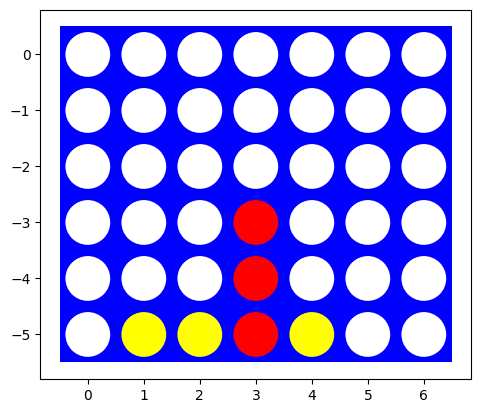

In [2]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()
    
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(state)`.
* The transition model `result(state, player, action)`.
* Check for terminal states `terminal(state)`.
* The utility function `utility(state, player)`.

The player argument is used so your agent can play red or yellow.
Make sure that all these functions work with boards of different sizes (number of columns and rows).
You can follow the [tic-tac-toe example from class.](https://colab.research.google.com/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_definitions.ipynb)

In [3]:
def actions(s):
    action = []
    col_actions = []

    for i in range(len(s[0])):
            if s[0][i] == 0:
                for j in range(len(s)):
                        if s[j][i] == 0:
                                col_actions.append(j)
                action.append((np.max(col_actions),i))
                col_actions = []
    return action

In [4]:
def result(s,player,a):
    r = np.copy(s)
    i,j = a
    r[i][j] = player
    return r

In [5]:
def check_outcome(state, debug = False):

    s = np.copy(state)
    
    # check for winner
    # first check to the right
    for j in range(len(s[0])-3):
        for i in range(len(s)):
            right = s[i][j] + s[i][j+1] + s[i][j+2] + s[i][j+3]
            if debug: print("right = ", right, "for ", (i,j))
            if right == 4 or right == -4:
                return s[i][j]

    # check down
    for j in range(len(s[0])):
            for i in range(len(s)-3):
                down = s[i][j] + s[i+1][j] + s[i+2][j] + s[i+3][j]
                if debug: print("down = ", down, "for ", (i,j))
                if down == 4 or down == -4:
                    return s[i][j]

    # check right diagonal
    for j in range(len(s[0])-3):
            for i in range(len(s)-3):
                right_diag = s[i][j] + s[i+1][j+1] + s[i+2][j+2] + s[i+3][j+3]
                if debug: print("right_diag = ", right_diag, "for ", (i,j))
                if right_diag == 4 or right_diag == -4:
                    return s[i][j]

    # check left diagonal
    for j in range(3,len(s[0])):
            for i in range(len(s)-3):
                left_diag = s[i][j] + s[i+1][j-1] + s[i+2][j-2] + s[i+3][j-3]
                if debug: print("left diag = ", left_diag, "for ", (i,j))
                if left_diag == 4 or left_diag == -4:
                    return s[i][j]

    # check for full board
    top_row = 0
    for i in range(len(s[0])):
        if s[0][i] != 0:
            top_row +=1
    if top_row >= len(s[0]):
        if debug: print('board full')
        return 0
    
    return None

In [6]:
board = [[0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1],
        [0, -1, 0, 1, 0, 0, 1],
        [0, 0, -1, 0, 0, 0, 0],
        [0, 1, 0, -1, 0, 0, 0],
        [1, 0, 0, -1, -1, -1, -1]]
print(check_outcome(board, debug = True))

right =  0 for  (0, 0)
right =  0 for  (1, 0)
right =  0 for  (2, 0)
right =  -1 for  (3, 0)
right =  0 for  (4, 0)
right =  0 for  (5, 0)
right =  0 for  (0, 1)
right =  0 for  (1, 1)
right =  0 for  (2, 1)
right =  -1 for  (3, 1)
right =  0 for  (4, 1)
right =  -2 for  (5, 1)
right =  0 for  (0, 2)
right =  0 for  (1, 2)
right =  1 for  (2, 2)
right =  -1 for  (3, 2)
right =  -1 for  (4, 2)
right =  -3 for  (5, 2)
right =  1 for  (0, 3)
right =  1 for  (1, 3)
right =  2 for  (2, 3)
right =  0 for  (3, 3)
right =  -1 for  (4, 3)
right =  -4 for  (5, 3)
-1


In [7]:
board = [[1, -1, 1, -1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]
print(check_outcome(board, debug = True))

right =  0 for  (0, 0)
right =  0 for  (1, 0)
right =  0 for  (2, 0)
right =  0 for  (3, 0)
right =  0 for  (4, 0)
right =  0 for  (5, 0)
right =  0 for  (0, 1)
right =  0 for  (1, 1)
right =  0 for  (2, 1)
right =  0 for  (3, 1)
right =  0 for  (4, 1)
right =  0 for  (5, 1)
right =  2 for  (0, 2)
right =  0 for  (1, 2)
right =  0 for  (2, 2)
right =  0 for  (3, 2)
right =  0 for  (4, 2)
right =  0 for  (5, 2)
right =  2 for  (0, 3)
right =  0 for  (1, 3)
right =  0 for  (2, 3)
right =  0 for  (3, 3)
right =  0 for  (4, 3)
right =  0 for  (5, 3)
down =  1 for  (0, 0)
down =  0 for  (1, 0)
down =  0 for  (2, 0)
down =  -1 for  (0, 1)
down =  0 for  (1, 1)
down =  0 for  (2, 1)
down =  1 for  (0, 2)
down =  0 for  (1, 2)
down =  0 for  (2, 2)
down =  -1 for  (0, 3)
down =  0 for  (1, 3)
down =  0 for  (2, 3)
down =  1 for  (0, 4)
down =  0 for  (1, 4)
down =  0 for  (2, 4)
down =  1 for  (0, 5)
down =  0 for  (1, 5)
down =  0 for  (2, 5)
down =  1 for  (0, 6)
down =  0 for  (1, 6)
down =

In [8]:
def terminal(s):
    return check_outcome(s) != None
def other(player):
    if player == 1: return -1
    else: return 1
def utility(s,player=1):
    outcome = check_outcome(s)
    if outcome == player:
        return 1
    elif outcome == 0:
        return 0
    elif outcome == other(player):
        return -1
    return None

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [9]:
def random_player(board,player=1):
    idx = np.random.randint(len(actions(board)))
    return actions(board)[idx]

In [10]:
def switch_player(player, r, y):
    # red = 1, yellow = -1
    if player == 1:
        return -1, y
    else:
        return 1, r

def play(r, y, N = 100, vis = False):
    """Let two agents play each other N times. x starts. x and y are agent functions that 
    get the board as the percept and return their next action."""
    results = {'red': 0, 'yellow': 0, 'draw': 0}
    
    for i in range(N):
        board = empty_board()
        player, fun = 1, r
        
        while True:
            a = fun(board, player)
            board = result(board, player, a)
            
            game_end = terminal(board)   # returns false if the game is not done.
            if game_end:
                outcome = check_outcome(board)
                if outcome == 1:
                    results['red'] += 1
                elif outcome == -1:
                    results['yellow'] += 1
                elif outcome == 0:
                    results['draw'] += 1
                if vis:
                    visualize(board)
                break
            
            player, fun = switch_player(player, r, y)   
    
    return results

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [11]:
# timeit: n ... how many times to execute the statement, 
#         r ... how many times to repeat the timer (default 5)

%time display(play(random_player, random_player, N = 100))

{'red': 55, 'yellow': 44, 'draw': 1}

CPU times: total: 1.62 s
Wall time: 2.29 s


## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points] 

Implement minimax search starting from a given board for specifying the player.

__Important Notes:__ 
* You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The game tree for a $6 \times 7$ board is huge and optimal algorithms need to visit each or a large percentage of all nodes in the tree. You can experiment with smaller boards like a $4 \times 4$ board first.

In [12]:
import math

In [13]:
def alpha_beta_search(board, player = 1):
    value, move = max_value_ab(board, player, -math.inf, +math.inf)
    return { "move": move, "value": value }

def max_value_ab(state, player, alpha, beta):  
    v = utility(state, player)
    if v is not None: return v, None
        
    v, move = -math.inf, None

    for a in actions(state):
        v2, a2 = min_value_ab(result(state, player, a), player, alpha, beta)
        
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            return v, move
    
    return v, move

def min_value_ab(state, player, alpha, beta):
    v = utility(state, player)
    if v is not None: return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in actions(state):
        v2, a2 = max_value_ab(result(state, other(player), a), player, alpha, beta)
        
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: 
            return v, move
    
    return v, move

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

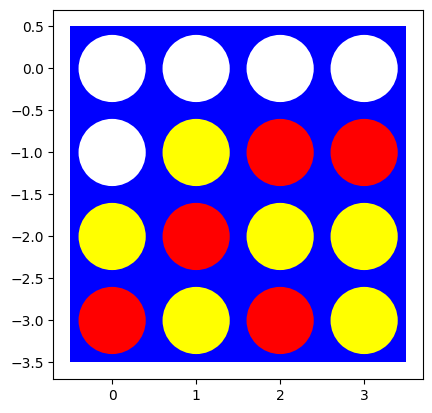

{'move': (0, 3), 'value': 1}

CPU times: total: 15.6 ms
Wall time: 15 ms


In [14]:
# board 1
board = [[0, 0, 0, 0],
         [0,-1, 1, 1],
         [-1,1,-1,-1],
         [1,-1, 1,-1]]
visualize(board)
%time display(alpha_beta_search(board))

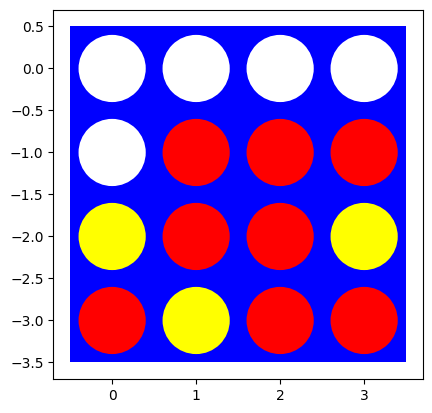

{'move': (1, 0), 'value': 1}

CPU times: total: 0 ns
Wall time: 2.99 ms


In [15]:
# board 2
board = [[0, 0, 0, 0],
         [0, 1, 1, 1],
         [-1,1, 1,-1],
         [1,-1, 1, 1]]
visualize(board)
%time display(alpha_beta_search(board))

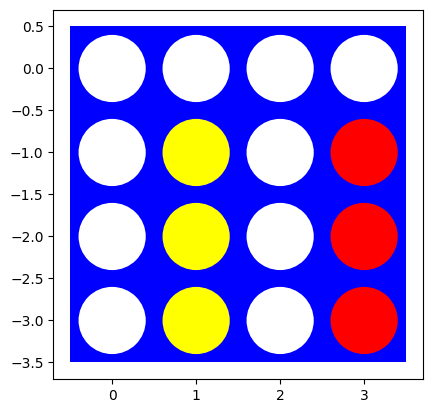

{'move': (0, 3), 'value': 1}

CPU times: total: 156 ms
Wall time: 157 ms


In [16]:
# board 3
board = [[0, 0, 0, 0],
         [0,-1, 0, 1],
         [0,-1, 0, 1],
         [0,-1, 0, 1]]
visualize(board)
%time display(alpha_beta_search(board))

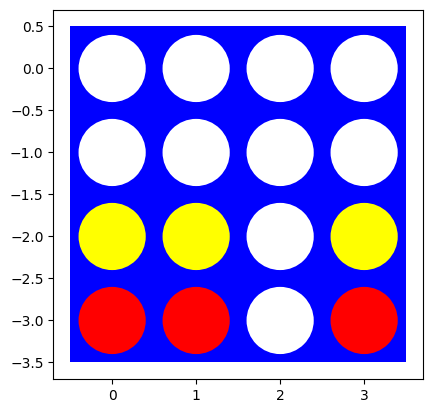

{'move': (3, 2), 'value': 1}

CPU times: total: 125 ms
Wall time: 120 ms


In [17]:
# board 4
board = [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [-1,-1,0,-1],
         [1, 1, 0, 1]]
visualize(board)
%time display(alpha_beta_search(board))

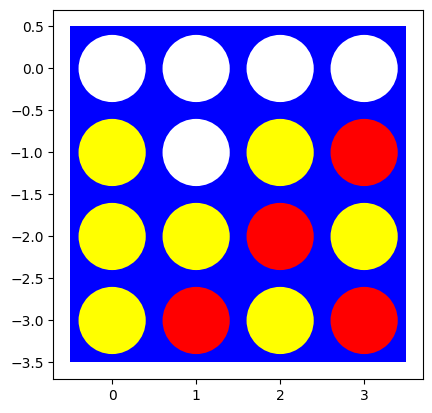

{'move': (0, 0), 'value': -1}

CPU times: total: 0 ns
Wall time: 3.98 ms


In [18]:
# board 5
board = [[0, 0, 0, 0],
         [-1,0,-1, 1],
         [-1,-1,1,-1],
         [-1, 1,-1,1]]
visualize(board)
%time display(alpha_beta_search(board))

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns/rows. Explain why using this algorithm on a standard $6 \times 7$ board is not feasible.

In [19]:
# 4x4 board
board = [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]

%time display(alpha_beta_search(board))

{'move': (3, 0), 'value': 0}

CPU times: total: 4.94 s
Wall time: 6.33 s


In [20]:
# 4x5 board
board = [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]

%time display(alpha_beta_search(board))

KeyboardInterrupt: 

In [ ]:
# 4x6 board
board = [[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]]
#%time display(alpha_beta_search(board))

In [ ]:
# 4x7 board
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]]

Chạy quá lâu em chạy khoảng 40'' nhưng vẫn chưa xong !

### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [21]:
# priority for 6x7
def actions(s):
    action = []
    col_actions = []
    priority = [0,0.5,1,2,1,0.5,0]

    for i in range(len(s[0])):
            if s[0][i] == 0:
                for j in range(len(s)):
                        if s[j][i] == 0:
                                col_actions.append(j)
                action.append((np.max(col_actions),i))
                col_actions = []

    priority_action = [a for _,a in sorted(zip(priority,action), reverse = True)]
    return priority_action

In [22]:
# priority for any size
def actions(s):
    action = []
    col_actions = []
    priority = []
    length = len(s[0])

    if length%2 == 0:
        p = 0
        for i in range(0,int(length/2)):
            if s[0][i] == 0:
                priority.append(p)
                p += 1
        for i in range(int(length/2), length):
            if s[0][i] == 0:
                p -= 1
                priority.append(p)
    else:
        p = -1
        for i in range(0,math.ceil(length/2)):
            if s[0][i] == 0:
                p += 1
                priority.append(p)
        for i in range(math.ceil(length/2), length):
            if s[0][i] == 0:
                p -= 1
                priority.append(p)
        
    for i in range(len(s[0])):
            if s[0][i] == 0:
                for j in range(len(s)):
                        if s[j][i] == 0:
                                col_actions.append(j)
                action.append((np.max(col_actions),i))
                col_actions = []

    priority_action = [a for _,a in sorted(zip(priority,action), reverse = True)]
    return priority_action

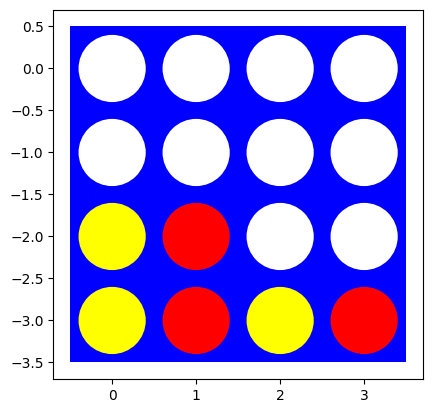

[(2, 2), (1, 1), (2, 3), (1, 0)]

In [23]:
board = [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [-1,1, 0, 0],
         [-1,1,-1, 1]]
visualize(board)
actions(board)

In [24]:
# 4x4 board
board = [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]

%time display(alpha_beta_search(board))

{'move': (3, 2), 'value': 0}

CPU times: total: 24.4 s
Wall time: 36.7 s


In [25]:
# 4x5 board
board = [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]

%time display(alpha_beta_search(board))

{'move': (3, 2), 'value': 0}

CPU times: total: 14min 20s
Wall time: 14min 52s


In [27]:
# import pandas as pd
# dict = {'Algorithm & Size' : ['No Move Ordering, 4x4','No Move Ordering, 4x5','Move Ordering, 4x4','Move Ordering, 4x5'], 
#         'Runtime' : ['']}
# df = pd.DataFrame(dict)
# display(df)

### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

In [28]:
# 6x7 board
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]]

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a $4 \times 4$ board. Analyze wins, losses and draws.

In [29]:
def play_four(r, y, N = 100, vis = False):
    """Let two agents play each other N times. x starts. x and y are agent functions that 
    get the board as the percept and return their next action."""
    results = {'red': 0, 'yellow': 0, 'draw': 0}
    
    for i in range(N):
        board = empty_board(shape=(4,4))
        player, fun = 1, r
        
        while True:
            a = fun(board, player)
            #print('action: ',a)
            board = result(board, player, a)
            
            game_end = terminal(board)   # returns false if the game is not done.
            if game_end:
                outcome = check_outcome(board)
                if outcome == 1:
                    results['red'] += 1
                elif outcome == -1:
                    results['yellow'] += 1
                elif outcome == 0:
                    results['draw'] += 1
                if vis:
                    visualize(board)
                break
            
            player, fun = switch_player(player, r, y)   
    
    return results

In [32]:
def ab_player(board,player=1):
    return list(alpha_beta_search_opening(board,player).values())[0]

In [34]:
# opening agent
%time display(play_four(ab_player, random_player, N = 100))

NameError: name 'alpha_beta_search_opening' is not defined

## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function. Make sure that the heuristic value stays in the correct range.

In [35]:
def eval_adjacent(adjacent,player):
    p_pieces = 0
    op_pieces = 0
    spaces = 0
    score = 0

    for p in adjacent:
        if p == player:
            p_pieces += 1
        elif p == -player:
            op_pieces += 1
        else:
            spaces += 1

    if p_pieces == 2 and spaces == 2:
        score = 0.05
    elif p_pieces == 2:
        score = 0.025
    elif p_pieces == 3 or op_pieces == 3:
        score = 0.1
    elif p_pieces == 1:
        score = 0.025

    return score

In [36]:
def eval_fun(state, player = 1):
    # first check if terminal
    s = state.copy()

    if utility(state, player) != None: return utility(state,player), True
    score = 0

    # check heuristic to the right
    for j in range(len(s[0])-3):
        for i in range(len(s)):
            right = [s[i][j], s[i][j+1], s[i][j+2], s[i][j+3]]
            score += eval_adjacent(right, player)
    
    # check heuristic down
    for j in range(len(s[0])):
        for i in range(len(s)-3):
            down = [s[i][j], s[i+1][j], s[i+2][j], s[i+3][j]]
            score += eval_adjacent(down, player)

    # check heuristic along right diagonal
    for j in range(len(s[0])-3):
        for i in range(len(s)-3):
            right_diag = [s[i][j], s[i+1][j+1], s[i+2][j+2], s[i+3][j+3]]
            score += eval_adjacent(right_diag, player)

    # check heuristic along left diagonal
    for j in range(3,len(s[0])):
        for i in range(len(s)-3):
            left_diag = [s[i][j], s[i+1][j-1], s[i+2][j-2], s[i+3][j-3]]
            score += eval_adjacent(left_diag, player)

    return score, False

### Cutting Off Search [10 points]

Modify your minimax search with alpha-beta pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [37]:
def alpha_beta_search_cutoff(board, cutoff = None, player = 1):
    value, move = max_value_ab_cutoff(board, player, -math.inf, +math.inf, 0, cutoff)
    return {"move" : move, "value" : value}

def max_value_ab_cutoff(state, player, alpha, beta, depth, cutoff):
    v, game_end = eval_fun(state, player)
    if((cutoff != None and depth >= cutoff) or game_end):
        if game_end:
            alpha, beta = v, v
        return v, None
    
    v, move = -math.inf, None

    for a in actions(state):
        v2, a2 = min_value_ab_cutoff(result(state, player, a), player, alpha, beta, depth+1, cutoff)
        if v2 >v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v>= beta: return v, move

    return v, move

def min_value_ab_cutoff(state, player, alpha, beta, depth, cutoff):
    v, game_end = eval_fun(state, player)
    if((cutoff != None and depth >= cutoff) or game_end):
        if game_end:
            alpha, beta = v, v
        return v, None
    
    v, move = +math.inf, None

    for a in actions(state):
        v2, a2 = max_value_ab_cutoff(result(state, other(player), a), player, alpha, beta, depth+1, cutoff)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: return v, move

    return v, move

In [38]:
# alpha beta search with opening moves
def alpha_beta_search_cutoff_opening(board, cutoff = None, player = 1):
    b = np.copy(board)
    if np.count_nonzero(b) < 6:
        a, v = opening(board,player)
        # keep same signature as regular return
        return {"move": a, "value": v}
                
    value, move = max_value_ab_cutoff(board, player, -math.inf, +math.inf, 0, cutoff)
    return {"move": move, "value": value}

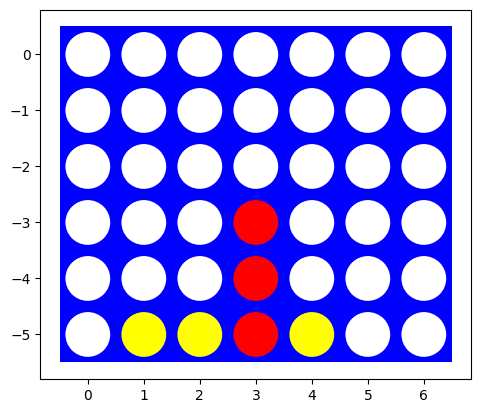

{'move': (4, 4), 'value': 1.624999999999999}

CPU times: total: 9.66 s
Wall time: 12.1 s


In [40]:
# cutoff = 5
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

%time display(alpha_beta_search_cutoff_opening(board, cutoff=8))

In [41]:
# cutoff = 5
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]]

%time display(alpha_beta_search_cutoff(board, cutoff=5))

{'move': (5, 3), 'value': 0.6750000000000003}

CPU times: total: 359 ms
Wall time: 382 ms


Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

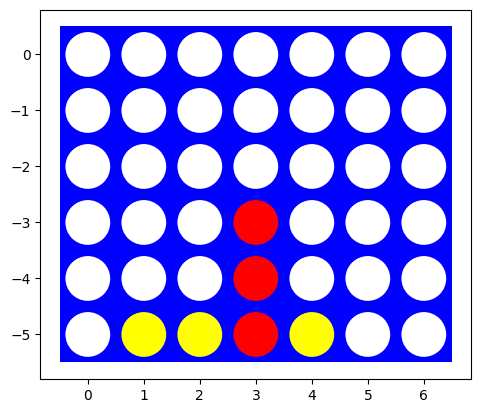

{'move': (4, 4), 'value': 1.624999999999999}

CPU times: total: 8.22 s
Wall time: 9.46 s


In [42]:
# board 1
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)
%time display(alpha_beta_search_cutoff_opening(board, cutoff=8))

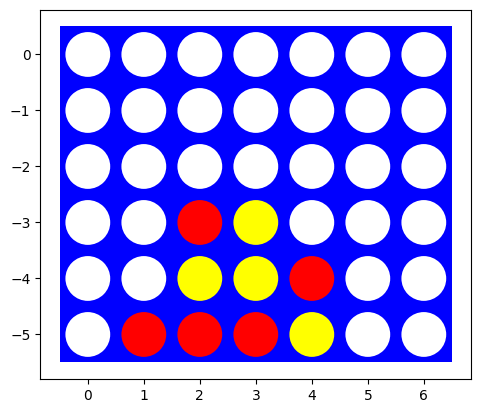

{'move': (2, 2), 'value': 1.7499999999999991}

CPU times: total: 19.2 s
Wall time: 21.8 s


In [43]:
# board 2
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1,-1, 0, 0, 0],
         [0, 0,-1,-1, 1, 0, 0],
         [0, 1, 1, 1,-1, 0, 0]]
visualize(board)
%time display(alpha_beta_search_cutoff_opening(board, cutoff=8))

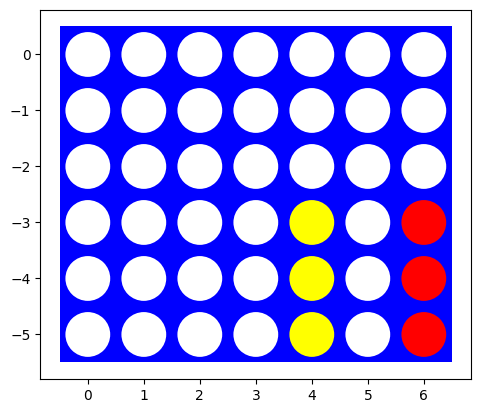

{'move': (2, 4), 'value': 1.2249999999999994}

CPU times: total: 9.02 s
Wall time: 10.1 s


In [44]:
# board 3
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0,-1, 0, 1],
         [0, 0, 0, 0,-1, 0, 1],
         [0, 0, 0, 0,-1, 0, 1]]
visualize(board)
%time display(alpha_beta_search_cutoff_opening(board, cutoff=8))

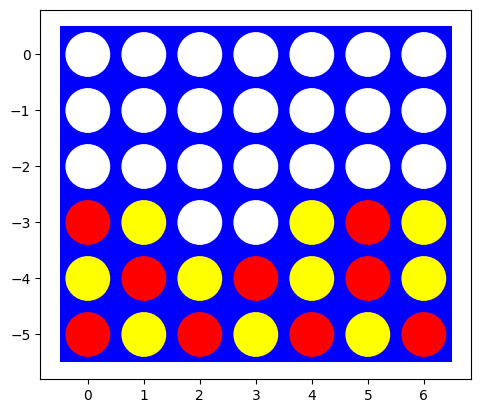

{'move': (3, 3), 'value': -1}

CPU times: total: 11.6 s
Wall time: 13.2 s


In [45]:
# board 4
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [1,-1, 0, 0,-1, 1,-1],
         [-1,1,-1, 1,-1, 1,-1],
         [1,-1, 1,-1, 1,-1, 1]]
visualize(board)
%time display(alpha_beta_search_cutoff_opening(board, cutoff=8))

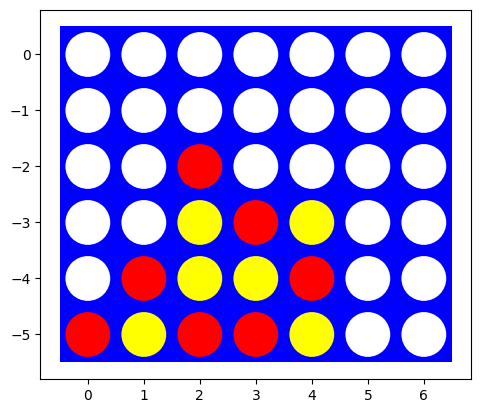

{'move': (2, 3), 'value': 2.3249999999999984}

CPU times: total: 27.9 s
Wall time: 30.4 s


In [46]:
# board 5
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 0,-1, 1,-1, 0, 0],
         [0, 1,-1,-1, 1, 0, 0],
         [1,-1, 1, 1,-1, 0, 0]]
visualize(board)
%time display(alpha_beta_search_cutoff_opening(board, cutoff=10))

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

### Playtime [5 points]

Let two heuristic search agents (different cutoff depth) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

## Challenge task [up to +10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above. 

In [20]:
# Your code/ answer goes here.

### Best First Move

Use your Monte Carlo Search to determine what the best first move for red is? Describe under what assumptions this is the "best" first move.  

In [21]:
# Your code/ answer goes here.